# Generic Runge-Kutta Code

This is an attempt to write a generic ordered runga kutta method for performance testing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import tqdm
import scipy.optimize

In [2]:
def dydx(x, y):
	return np.sin(2.0*np.pi/10*x)
 
# Finds value of y for a given x using step size h
# and initial value y0 at x0.
def rungeKuttaSimp(x0, y0, x, h):
    # Count number of iterations using step size or
    # step height h
    n = (int)((x - x0)/h)
    # Iterate for number of iterations
    y = y0
    for i in range(1, n + 1):
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * dydx(x0, y)
        k2 = h * dydx(x0 + 0.5 * h, y + 0.5 * k1)
        k3 = h * dydx(x0 + 0.5 * h, y + 0.5 * k2)
        k4 = h * dydx(x0 + h, y + k3)
 
        # Update next value of y
        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
 
        # Update next value of x
        x0 = x0 + h
    return y

@numba.jit
def norm(a):
	return a/vecLen(a)

@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))


def rungeKutta(function, ButcherTableau, x0, y0, x, h, params = None, normalize=False):
	rkA, rkB, rkC = ButcherTableau
	n = (int)((x-x0)/h)
	s = len(rkC)
	y = y0
	z = np.zeros_like(y)
	results = [(x0, *y0, *z)]
	for n in range(1, n+1):
		k = None
		if params is not None:
			k = [function(x0, y, *params)]
		else:
			k = [function(x0, y)]
		for i in range(0, s):
			temp = 0
			for j in range(0, i):
				temp+=rkA[i][j]*k[j]
			t = None
			if params is not None:
				t = function(x0+h*temp, y+h*k[i], *params)
			else:
				t = function(x0+h*temp, y+h*k[i])
			#print(t)
			k.append(t)
		t = 0
		for i in range(s):
			t+=rkB[i]*k[i]
		y = np.add(y, h*t)
		if normalize:
			y = norm(y)
		x0 = x0 + h
		results.append((x0, *y, *(h*t)))
	return results

def forwardEuler():
	rkA = np.array([[0]])
	rkB = np.array([1])
	rkC = np.array([0])
	return rkA, rkB, rkC

def midpointMethod():
	rkA = np.array([[0, 0], [0.5, 0]])
	rkB = np.array([0, 1])
	rkC = np.array([0, 0.5])
	return rkA, rkB, rkC

def RK3():
	rkA = np.array([[0, 0, 0], [0.5, 0, 0], [-1, 2, 0]])
	rkB = np.array([1.0/6.0, 2.0/3.0, 1.0/6.0])
	rkC = np.array([0.0, 0.5, 1.0])
	return rkA, rkB, rkC

def RK4():
	rkA = np.array([[0, 0, 0, 0], [0.5, 0, 0, 0], [0, 0.5, 0, 0], [0, 0, 1, 0]])
	rkB = np.array([1.0/6.0, 1.0/3.0, 1.0/3.0, 1.0/6.0])
	rkC = np.array([0, 0.5, 0.5, 1.0])
	return rkA, rkB, rkC

def RK45():
	rkA = np.array([[0, 0, 0, 0, 0], 
		   [1/4, 0, 0, 0, 0],
		   [3/32, 9/32, 0, 0, 0],
		   [1932/2197, -7200/2197, 7296/2197, 0, 0],
		   [439/216, -8, 3680/513, -845/4140, 0],
		   [-8/27, 2, -3544/2565, 1859/4104, -11/40]])
	rkB = np.array([16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55])
	rkC = np.array([0, 1/4, 3/8, 12/13, 1, 1/2])
	return rkA, rkB, rkC

def CashKarp6_4_5():
	rkA = np.array([[0, 0, 0, 0, 0, 0],
		   [1/5, 0, 0, 0, 0, 0],
		   [3/40, 9/40, 0, 0, 0, 0],
		   [3/10, -9/10, 6/5, 0, 0, 0],
		   [-11/54, 5/2, -70/27, 35/2, 0, 0],
		   [1631/55296, 175/512, 575/13824, 44275/110592, 253/4096, 0]])
	rkB = np.array([37/378, 0, 250/621, 125/594, 0, 512/1771])
	rkC = np.array([0, 1/5, 3/10, 3/5, 1, 7/8])
	return rkA, rkB, rkC

## Repeating the testing from the other code now

In [14]:
@numba.jit
def calcGamma(v):
	return 1.0/np.sqrt(1-(v/299792458.0)**2.0)

@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))

@numba.jit
def BMT(t, s, x, v, a, B0, E0, consts):
	gamma = calcGamma(vecLen(v))
	BPrime = gamma*B0+(1-gamma)*(np.dot(B0, v)) *v/vecLen(v)**2.0 - gamma/89875517873681764.0*np.cross(v, E0)
	wt = gamma**2.0 / (89875517873681764.0*(gamma+1))*np.cross(a, v)
	#update the spin
	crossVal = -2.0*consts['mu']/(gamma*consts['hbar'])*BPrime + wt
	s = np.cross(crossVal, s)
	return s

In [20]:
precision = np.float64
neutType = np.dtype([('x', precision, 3), ('v', precision, 3), ('s', precision, 3)])

constType = np.dtype([('m', precision), ('dn', precision), 
					  ('mu', precision), ('hbar', precision),
					  ('gamma', precision)])
consts = np.array(1, dtype=constType)
consts['m']=1.674927485E-27 #units of kg
consts['dn'] = 0.0 #electric dipole moment
consts['mu'] = -0.96623650E-26
consts['hbar'] = 1.054571817E-34
consts['gamma'] = 2.0E8

E = np.array([0, 0, 75.0E5], dtype=precision)
E = np.array([0, 0, 0], dtype=precision)
#B = np.array([0, 0, 3.0E-6], dtype=precision)

def B(t):
	return np.array([0, 0, 19.1026874e-6*np.cos(3000*t)],  dtype=precision)
#@numba.jit
def Bloch(t, s, x, v, a, B0, E0, consts):
	#print(t, s, x, v)
	return np.cross(consts['gamma']*s, B0(t))

s = np.array([1, 0, 0], dtype=precision)
v = np.array([1.0E-10, 0, 0], dtype=precision)
a = np.array([0, 0, 0], dtype=precision)
w = consts['gamma']*vecLen(B(0)) #calculate the frequency
period = abs(2.0*np.pi/w)
print(period, 1.0/period)

0.001644581512436723 608.0574252098532


In [22]:
numSteps = np.logspace(0, 4, num=40, endpoint=True).astype(int)
numSteps = np.sort(np.unique(numSteps))
length = period * 10

spinsEuler = []
spinsMidpoint = []
spinsRK3 = []
spinsRK4 = []
spinsRK45 = []
spinsCK645 = []
timeScales = []
sinIntegrator = []

for numIter in tqdm.tqdm(numSteps):
	h = period/numIter
	spinsEuler.append(np.array(rungeKutta(Bloch, forwardEuler(), 0, s, length, h, params=[None, v, a, B, E, consts], normalize=True)))
	#spinsMidpoint.append(np.array(rungeKutta(Bloch, midpointMethod(), 0, s, length, h, params=[None, v, a, B, E, consts], normalize=True)))
	#spinsRK3.append(np.array(rungeKutta(Bloch, RK3(), 0, s, length, h, params=[None, v, a, B, E, consts], normalize=True)))
	#spinsRK4.append(np.array(rungeKutta(Bloch, RK4(), 0, s, length, h, params=[None, v, a, B, E, consts], normalize=True)))
	#spinsRK45.append(np.array(rungeKutta(Bloch, RK45(), 0, s, length, h, params=[None, v, a, B, E, consts], normalize=True)))
	#spinsCK645.append(np.array(rungeKutta(Bloch, CashKarp6_4_5(), 0, s, length, h, params=[None, v, a, B, E, consts], normalize=True)))

  0%|                                                                                            | 0/37 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [23]:
demoLocs = [5, 8, 12, -1]
for loc in demoLocs:
	plt.plot(spinsCK645[loc][:,0], spinsCK645[loc][:,1], label=len(spinsCK645[loc]))
#plt.xlim(0, period)
plt.legend()
plt.title(r'Comparing $S_x$ for different integrator steps')
plt.ylabel(r'S_x')
plt.xlabel('Time (s)')
#plt.yscale('log')
plt.show()

IndexError: list index out of range

In [24]:
def func(t, w):
	return np.cos(w*t)
w = abs(w)
print(w)
fitResEul = []
for spin in spinsEuler[10:]:
	popt, pcov = scipy.optimize.curve_fit(func, spin[:,0], spin[:,1], p0=[w])
	fitResEul.append(abs(popt[0]-w)/w*100)

fitResMid = []
for spin in spinsMidpoint[10:]:
	popt, pcov = scipy.optimize.curve_fit(func, spin[:,0], spin[:,1], p0=[w])
	fitResMid.append(abs(popt[0]-w)/w*100)

fitResRK3 = []
for spin in spinsRK3[10:]:
	popt, pcov = scipy.optimize.curve_fit(func, spin[:,0], spin[:,1], p0=[w])
	fitResRK3.append(abs(popt[0]-w)/w*100)

fitResRK4 = []
for spin in spinsRK4[10:]:
	popt, pcov = scipy.optimize.curve_fit(func, spin[:,0], spin[:,1], p0=[w])
	fitResRK4.append(abs(popt[0]-w)/w*100)

fitResRK45 = []
for spin in spinsRK45[10:]:
	popt, pcov = scipy.optimize.curve_fit(func, spin[:,0], spin[:,1], p0=[w])
	fitResRK45.append(abs(popt[0]-w)/w*100)

fitResCK645 = []
for spin in spinsCK645[10:]:
	popt, pcov = scipy.optimize.curve_fit(func, spin[:,0], spin[:,1], p0=[w])
	fitResCK645.append(abs(popt[0]-w)/w*100)

3820.53748


In [33]:
methods = ['DOP853', 'RK45', 'RK23', 'Radau']
results = []
t = (0.0, 1.0)
for method in methods:
	tols = []
	freqErrs = []
	averageStepSize = []
	for tol in np.logspace(-2, -12, 10):
		res = scipy.integrate.solve_ivp(Bloch, (t[0], t[-1]), s.copy(), method=method, args=(None, v, a, B, E, consts), first_step = 0.001, rtol=tol, atol=tol)
		#popt, pcov = scipy.optimize.curve_fit(func, res.t, res.y.T[:,0], p0=[w])
		tols.append(tol)
		#freqErrs.append(abs(popt[0]-w)/w*100)
		averageStepSize.append(np.mean(np.diff(res.t)))
		print(method, tol, np.mean(np.diff(res.t)))
	results.append((tols, freqErrs, averageStepSize))

DOP853 0.01 0.0006402048655569782
DOP853 0.000774263682681127 0.0005232862375719519
DOP853 5.994842503189409e-05 0.0003929273084479371
DOP853 4.641588833612773e-06 0.00027662517289073305
DOP853 3.5938136638046254e-07 0.00019778481012658228
DOP853 2.782559402207126e-08 0.00014384349827387802
DOP853 2.154434690031878e-09 0.00010422094841063054
DOP853 1.6681005372000558e-10 7.560293339381567e-05
DOP853 1.2915496650148827e-11 5.511463844797178e-05
DOP853 1e-12 4.007212983370066e-05
RK45 0.01 0.00044822949350067237
RK45 0.000774263682681127 0.0002944640753828033
RK45 5.994842503189409e-05 0.0001904036557501904
RK45 4.641588833612773e-06 0.00011636025133814289
RK45 3.5938136638046254e-07 7.139797229758674e-05
RK45 2.782559402207126e-08 4.337830217325294e-05
RK45 2.154434690031878e-09 2.6180066497368904e-05
RK45 1.6681005372000558e-10 1.5747535510692576e-05
RK45 1.2915496650148827e-11 9.459127111750129e-06
RK45 1e-12 5.673662292273039e-06
RK23 0.01 0.00040048057669203043
RK23 0.00077426368268

/tmp/ipykernel_532/2825311497.py:23: RuntimeWarning: overflow encountered in multiply
  return np.cross(consts['gamma']*s, B0(t))
/home/david/anaconda3/lib/python3.9/site-packages/numpy/core/numeric.py:1654: RuntimeWarning: invalid value encountered in multiply
  tmp = array(a2 * b1)
/home/david/anaconda3/lib/python3.9/site-packages/numpy/core/numeric.py:1656: RuntimeWarning: invalid value encountered in multiply
  multiply(a2, b0, out=cp1)


ValueError: array must not contain infs or NaNs

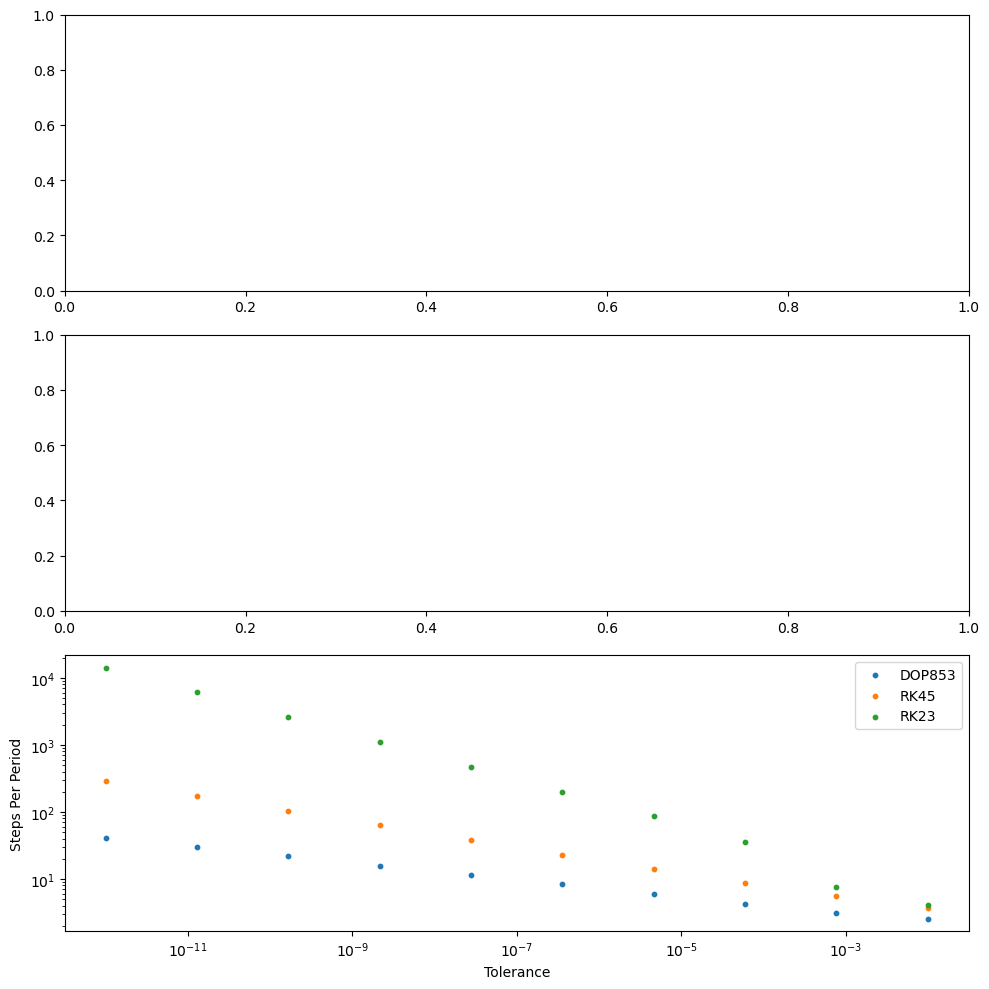

In [37]:
fig, axs = plt.subplots(3, figsize=(10, 10), layout='tight')
'''
axs[0].set_title('Testing with Different Integration Methods')
for res, name in zip(results, methods):
	axs[0].scatter(res[0], res[1], label=name, s=10)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_xlabel('Solver Tolerance')
axs[0].set_ylabel('% Frequency Shift')

for res, name in zip(results, methods):
	axs[1].scatter(res[2], res[1], label=name, s=10)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel('Average Step Size (s)')
axs[1].set_ylabel('% Frequency Shift')
'''
for res, name in zip(results, methods):
	axs[2].scatter(res[0], period/np.array(res[2]), label=name, s=10)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].legend()
axs[2].set_xlabel('Tolerance')
axs[2].set_ylabel('Steps Per Period')

plt.show()

In [15]:
fitResScipy = []
spinsScipy = []
for spin in spinsCK645[10:]:
	t = spin[:,0]
	res = scipy.integrate.solve_ivp(Bloch, (t[0], t[-1]), s.copy(), method='RK45', args=(None, v, a, B, E, consts), t_eval=t, first_step = 0.000001, rtol=1e-12)
	spinsScipy.append([res.t, res.y.T])
	popt, pcov = scipy.optimize.curve_fit(func, res.t, res.y.T[:,0], p0=[w])
	fitResScipy.append(abs(popt[0]-w)/w*100)

211
271
341
431
551
701
881
1121
1421
1801
2281
2891
3661
4641
5871
7441
9421
11931
15111
19141
24241
30701
38881
49231
62351
78961
100001


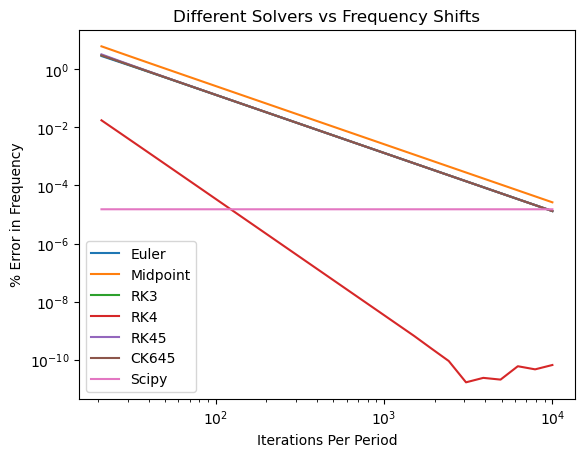

In [12]:
plt.plot(numSteps[10:], fitResEul, label='Euler')
plt.plot(numSteps[10:], fitResMid, label='Midpoint')
plt.plot(numSteps[10:], fitResRK3, label='RK3')
plt.plot(numSteps[10:], fitResRK4, label='RK4')
plt.plot(numSteps[10:], fitResRK45, label='RK45')
plt.plot(numSteps[10:], fitResCK645, label='CK645')
plt.plot(numSteps[10:], fitResScipy, label='Scipy')
plt.title('Different Solvers vs Frequency Shifts')
plt.ylabel('% Error in Frequency')
plt.xlabel('Iterations Per Period')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

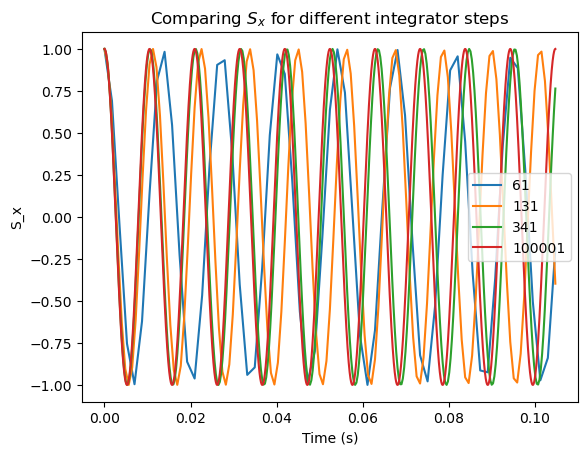

In [198]:
demoLocs = [5, 8, 12, -1]
for loc in demoLocs:
	plt.plot(spinsEuler[loc][:,0], spinsEuler[loc][:,1], label=len(spinsEuler[loc]))
#plt.xlim(0, period)
plt.legend()
plt.title(r'Comparing $S_x$ for different integrator steps')
plt.ylabel(r'S_x')
plt.xlabel('Time (s)')
#plt.yscale('log')
plt.show()

In [75]:
#loading in matt's result
mattRess = []
#for i in [100, 150, 250, 500, 1000, 10000, 100000]:
for i in [200, 400, 800, 1000, 5000, 10000, 15000, 20000, 40000, 100000]:
	mattRess.append(np.genfromtxt('/home/david/Spin-Tracking/test'+str(i)+'.txt', skip_header=1, delimiter=','))

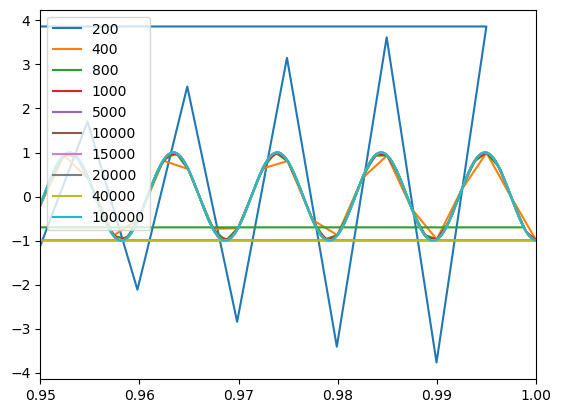

In [80]:
def func(t, w):
	return np.cos(w*t)

results = []
for res in mattRess:
	name=len(res[:,0])
	plt.plot(res[:,0], res[:,1], label=name)
	popt, pcov = scipy.optimize.curve_fit(func, res[:,0], res[:,1], p0=[w])
	results.append((name, abs(popt[0]-w)/w*100))
results = np.array(results)
plt.legend()
plt.xlim(0.95, 1)
plt.show()

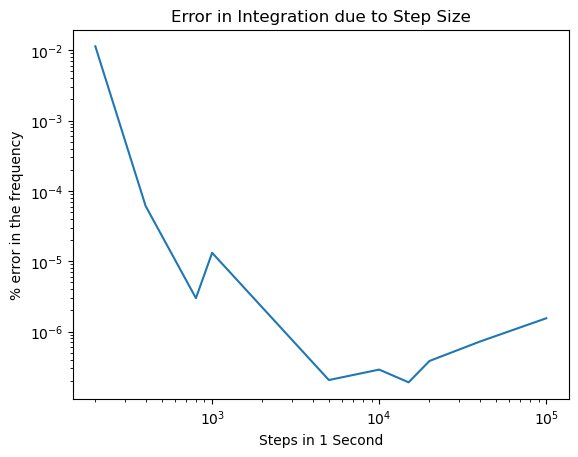

In [83]:
plt.plot(results[:,0], results[:,1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Steps in 1 Second')
plt.ylabel('% error in the frequency')
plt.title('Error in Integration due to Step Size')
plt.show()

In [39]:
freqs

[2.0470882115356898e-07, 3.8227165077842074e-07, 1.5462708612782687e-06]

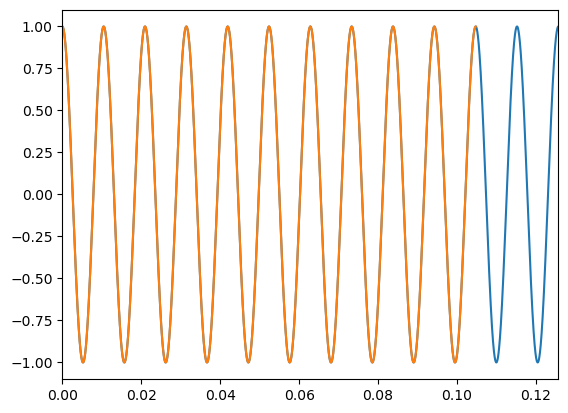

In [205]:
plt.plot(mattsRes[:,0], mattsRes[:,1])
plt.plot(spinsCK645[-1][:,0], spinsCK645[-1][:,1])
plt.xlim(0, period*12)
plt.show()